# Car Price Prediction Analysis

## 1. Importing Necessary Libraries

In [38]:

import pandas as pd
import numpy as np
import pprint
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_docs as tfdocs
from tensorflow import keras
from tensorflow.keras import layers, activations, Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


## 2. Loading the Datasee


In [39]:
dataset = pd.read_csv('car_price_prediction.csv')
dataset.sample(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
5580,45667168,12858,1408,FORD,Transit,2007,Microbus,No,Diesel,2.2 Turbo,175000 km,4.0,Manual,Front,04-May,Left wheel,White,2
2807,45810634,10697,363,CHEVROLET,Spark,2014,Hatchback,Yes,Petrol,1,95100 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
13930,45795977,23521,-,JEEP,Compass,2011,Jeep,No,LPG,2.4,104000 km,4.0,Automatic,4x4,04-May,Left wheel,Grey,10
15548,45732744,10349,639,HYUNDAI,Sonata,2014,Sedan,Yes,LPG,2,406314 km,4.0,Automatic,Front,04-May,Left wheel,White,4
13384,45797532,7840,-,OPEL,Vectra,2000,Universal,No,Petrol,1.8,217500 km,4.0,Manual,Front,04-May,Left wheel,Silver,4
6704,45792577,4077,-,OPEL,Vectra,1997,Sedan,No,CNG,1.6,0 km,4.0,Manual,Front,04-May,Left wheel,Carnelian red,2
12417,45647997,3136,781,TOYOTA,Camry,2012,Sedan,Yes,Hybrid,2.5,159379 km,4.0,Automatic,Front,04-May,Left wheel,White,12
11652,45814828,1882,862,TOYOTA,Camry,2011,Sedan,Yes,Petrol,2.5,236936 km,4.0,Automatic,Front,04-May,Left wheel,Blue,12
4105,45771649,862,584,KIA,Avella,2014,Sedan,Yes,Petrol,1.8,185334 km,4.0,Automatic,Front,04-May,Left wheel,Silver,11
3246,44825564,9722,1032,NISSAN,Note,2012,Hatchback,No,Petrol,1.2,69000 km,4.0,Automatic,Front,04-May,Right-hand drive,Black,6


## 3. Exploratory Data Analysis (EDA)

In [40]:
dataset.shape

(19237, 18)

In [41]:
dataset.isna().sum()


ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [42]:
dataset[['Levy', 'Engine volume', 'Cylinders']].describe()


,Cylinders
count,19237.000000
mean,4.582991
std,1.199933
min,1.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,16.000000


### Checking the Most Common Manufacturers

In [43]:
dataset['Manufacturer'].value_counts()


Manufacturer
HYUNDAI          3769
TOYOTA           3662
MERCEDES-BENZ    2076
FORD             1111
CHEVROLET        1069
                 ... 
TESLA               1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 65, dtype: int64

### Price Distribution - Boxplot

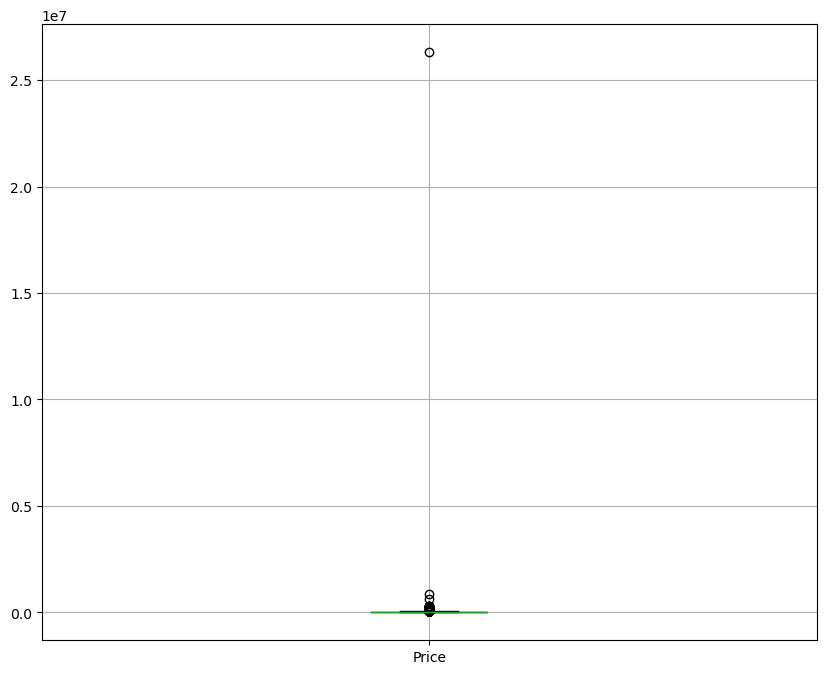

In [44]:
plt.figure(figsize=(10, 8))
dataset.boxplot('Price')
plt.show()


### Price Distribution - Kernel Density Estimate (KDE)

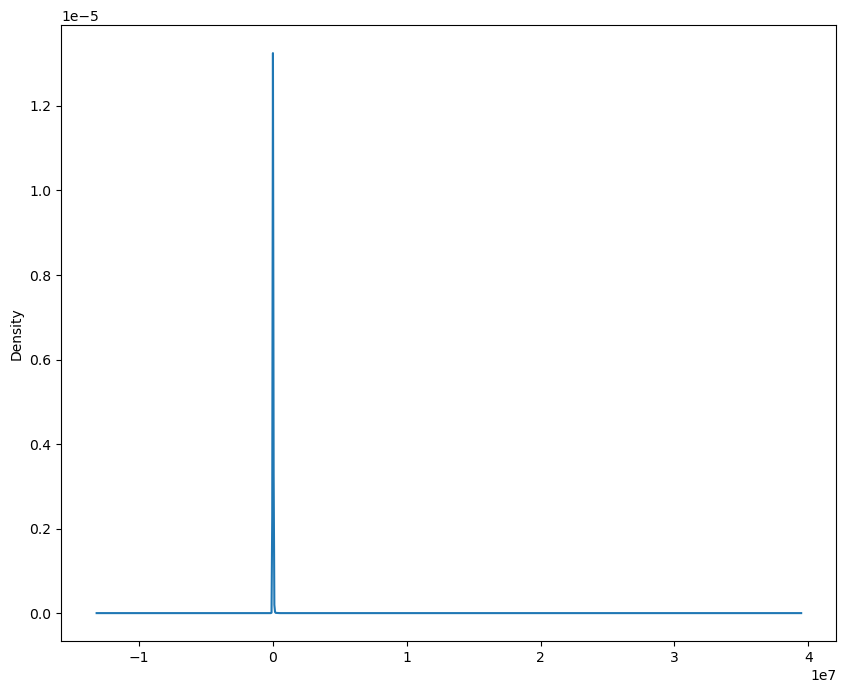

In [45]:
plt.figure(figsize=(10, 8))
dataset['Price'].plot.kde()
plt.show()


### Price vs Manufacturer - Scatter Plot

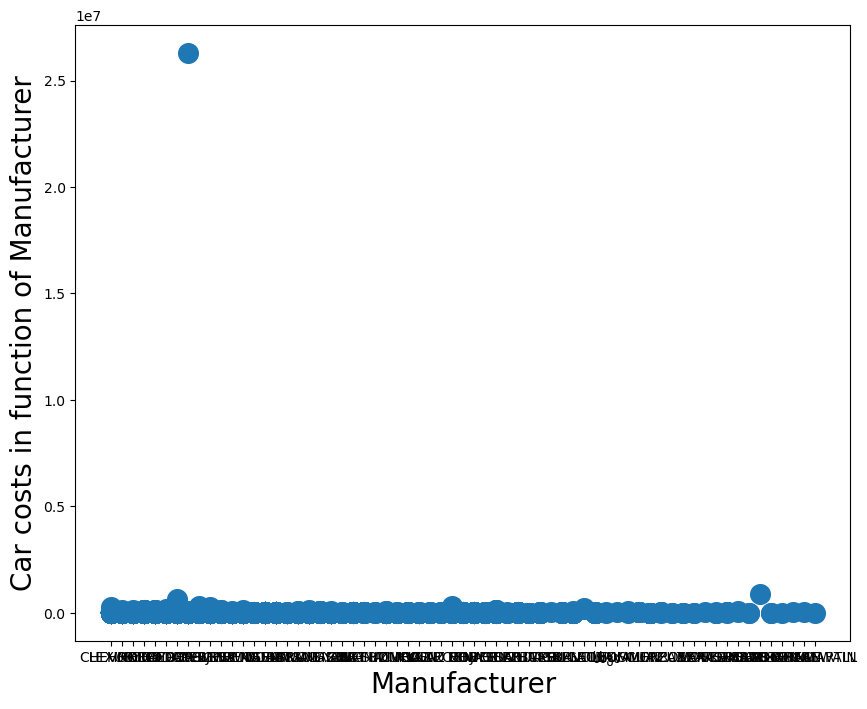

In [46]:
plt.figure(figsize=(10, 8))
plt.scatter(dataset['Manufacturer'], dataset['Price'], s=200)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Car costs in function of Manufacturer', fontsize=20)
plt.show()


## 4. Data Preprocessing
### 4.1 Handling Missing and Non-Numeric Values


In [47]:

dataset['Levy'] = pd.to_numeric(dataset['Levy'], errors='coerce').fillna(0)
dataset['Engine volume'] = dataset['Engine volume'].str.extract(r'(\d+\.?\d*)').astype(float)
dataset['Mileage'] = dataset['Mileage'].str.replace(' km', '').astype(int)


### One-Hot Encoding Categorical Features

In [48]:
categorical_features = [
    'Manufacturer', 'Model', 'Category', 'Leather interior',
    'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'
]
dataset = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)


### Normalizing Numeric Features

In [49]:
numeric_features = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
scaler = MinMaxScaler()
dataset[numeric_features] = scaler.fit_transform(dataset[numeric_features])


### Splitting the Data into Features and Labels

In [50]:
X = dataset.drop(columns=['ID', 'Price'])
y = dataset['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 5. Building the Base Model


In [51]:
base_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

base_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [52]:
print(X_train.dtypes)
print(y_train.dtypes)


Levy              float64
Prod. year        float64
Engine volume     float64
Mileage           float64
Cylinders         float64
                   ...   
Color_Red            bool
Color_Silver         bool
Color_Sky blue       bool
Color_White          bool
Color_Yellow         bool
Length: 1699, dtype: object
int64


In [53]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')


In [54]:
print(X_train.isna().sum())  # Check missing values
print(y_train.isna().sum())

X_train.fillna(0, inplace=True)  # Replace NaNs with 0 (or use another strategy)
y_train.fillna(0, inplace=True)


Levy              0
Prod. year        0
Engine volume     0
Mileage           0
Cylinders         0
                 ..
Color_Red         0
Color_Silver      0
Color_Sky blue    0
Color_White       0
Color_Yellow      0
Length: 1699, dtype: int64
0


Convert to NumPy Array with Correct Data Type

In [55]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)


### 5.1 Training the Base Model


In [56]:
base_history = base_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
385/385 [==============================] - 2s 3ms/step - loss: 56938020864.0000 - mae: 19113.0488 - val_loss: 520616416.0000 - val_mae: 14998.0654
Epoch 2/50
385/385 [==============================] - 1s 3ms/step - loss: 56778629120.0000 - mae: 15863.7139 - val_loss: 361258240.0000 - val_mae: 11596.2676
Epoch 3/50
385/385 [==============================] - 1s 3ms/step - loss: 56648404992.0000 - mae: 13824.1152 - val_loss: 304076576.0000 - val_mae: 11099.6035
Epoch 4/50
385/385 [==============================] - 1s 3ms/step - loss: 56606208000.0000 - mae: 13692.2402 - val_loss: 290665504.0000 - val_mae: 11316.5459
Epoch 5/50
385/385 [==============================] - 1s 3ms/step - loss: 56589393920.0000 - mae: 13668.2666 - val_loss: 281759136.0000 - val_mae: 11146.0713
Epoch 6/50
385/385 [==============================] - 1s 3ms/step - loss: 56576671744.0000 - mae: 13483.3125 - val_loss: 273792384.0000 - val_mae: 10938.3018
Epoch 7/50
385/385 [==============================] 

In [58]:
print(X_test.dtypes)
print(y_test.dtypes)
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')
print(X_test.isna().sum())  # Check missing values
print(y_test.isna().sum())
X_test.fillna(0, inplace=True)  # Replace NaNs with 0 (or another strategy)
y_test.fillna(0, inplace=True)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


Levy              float64
Prod. year        float64
Engine volume     float64
Mileage           float64
Cylinders         float64
                   ...   
Color_Red            bool
Color_Silver         bool
Color_Sky blue       bool
Color_White          bool
Color_Yellow         bool
Length: 1699, dtype: object
int64
Levy              0
Prod. year        0
Engine volume     0
Mileage           0
Cylinders         0
                 ..
Color_Red         0
Color_Silver      0
Color_Sky blue    0
Color_White       0
Color_Yellow      0
Length: 1699, dtype: int64
0


### Evaluating the Base Model

In [59]:
base_loss, base_mae = base_model.evaluate(X_test, y_test, verbose=0)
print(f"Base Model - Mean Absolute Error: {base_mae}")


Base Model - Mean Absolute Error: 9860.1962890625


## 6. Building an Enhanced Model with Dropout Layers


In [61]:
def build_custom_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

enhanced_model = build_custom_model(X_train.shape[1])

enhanced_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

### Training the Enhanced Model

In [62]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

enhanced_history = enhanced_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
385/385 [==============================] - 3s 5ms/step - loss: 56797122560.0000 - mae: 16521.2109 - val_loss: 295499968.0000 - val_mae: 11576.8516
Epoch 2/100
385/385 [==============================] - 2s 4ms/step - loss: 56570204160.0000 - mae: 13602.9629 - val_loss: 262815568.0000 - val_mae: 10803.3154
Epoch 3/100
385/385 [==============================] - 2s 4ms/step - loss: 56539541504.0000 - mae: 12950.8516 - val_loss: 247675424.0000 - val_mae: 10269.6650
Epoch 4/100
385/385 [==============================] - 2s 4ms/step - loss: 56519602176.0000 - mae: 12635.6289 - val_loss: 241443584.0000 - val_mae: 10344.8965
Epoch 5/100
385/385 [==============================] - 2s 4ms/step - loss: 56495755264.0000 - mae: 12501.4785 - val_loss: 232687008.0000 - val_mae: 9981.2529
Epoch 6/100
385/385 [==============================] - 2s 4ms/step - loss: 56470011904.0000 - mae: 12326.4023 - val_loss: 228252768.0000 - val_mae: 9934.9346
Epoch 7/100
385/385 [===========================

### Evaluating the Enhanced Model

In [63]:
enhanced_loss, enhanced_mae = enhanced_model.evaluate(X_test, y_test, verbose=0)
print(f"Enhanced Model - Mean Absolute Error: {enhanced_mae}")


Enhanced Model - Mean Absolute Error: 9640.529296875


### Comparing Model Performance

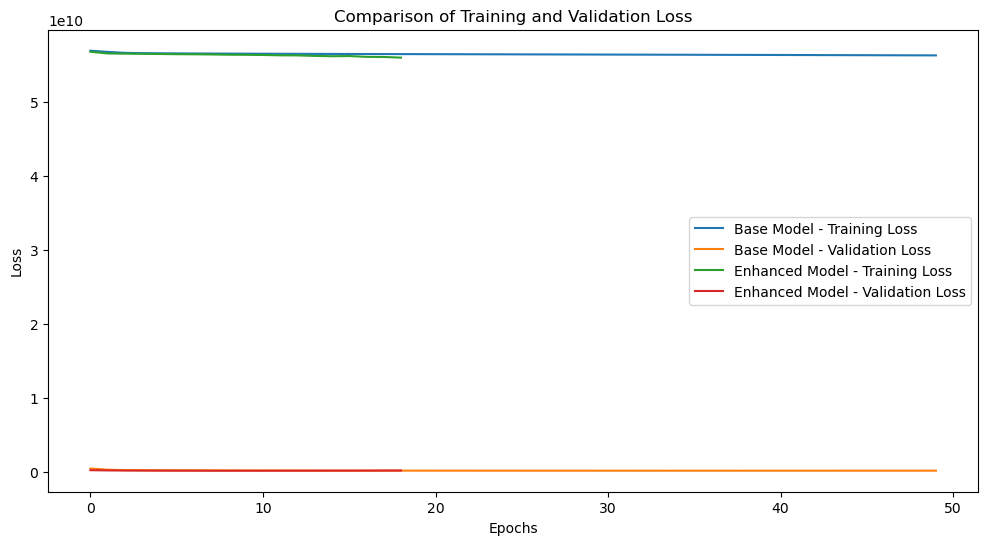

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(base_history.history['loss'], label='Base Model - Training Loss')
plt.plot(base_history.history['val_loss'], label='Base Model - Validation Loss')
plt.plot(enhanced_history.history['loss'], label='Enhanced Model - Training Loss')
plt.plot(enhanced_history.history['val_loss'], label='Enhanced Model - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Comparison of Training and Validation Loss')
plt.show()


In [66]:
print(f"Base Model MAE: {base_mae}")
print(f"Enhanced Model MAE: {enhanced_mae}")

Base Model MAE: 9860.1962890625
Enhanced Model MAE: 9640.529296875


## 7. Creating a Custom Dense Layer

In [65]:
class MyDense(layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(MyDense, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units))

    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel)
        if self.activation is not None:
            output = self.activation(output)
        return output